## Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', 500)
plt.style.use('fivethirtyeight')

## Load Data

In [34]:
df_gender_submission = pd.read_csv('../data/gender_submission.csv')
display(df_gender_submission.head())
df_gender_submission.info()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [35]:
df_test = pd.read_csv('../data/test.csv')
display(df_test.head())
df_test.info()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [36]:
df_train = pd.read_csv('../data/train.csv')
display(df_train.head())
df_train.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Feature Engineering
Creating some features that can be useful potentially 
- Family Size (see how big a fam is)
- Family Group (seeing if someone was single, had a family, or a big family aboard)
- Title (See by name if it was a man, woman, etc.)
- Age Group (Seeing the age group these people were in)
- BoatFarePerPerson (Seeing how each ticket cost)

In [37]:
# Work on a copy so we can always revert
viz = df_train.copy()

# The Family features (Size and Group) are derived from SibSp and Parch, so we can keep those for now and drop later if we want
viz["FamilySize"] = viz["SibSp"].fillna(0) + viz["Parch"].fillna(0) + 1

viz["FamilyGroup"] = pd.cut(
    viz["FamilySize"],
    bins=[0, 1, 4, viz["FamilySize"].max()],   # dynamic upper bound
    labels=["Alone", "Small Family (2–4)", "Large Family (5+)"],
    include_lowest=True
)

#Title from Name 
viz["Title"] = viz["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

# Normalizing those common titles the fun stuff
viz["Title"] = viz["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})

# Getting those extra rare titles into one bucket
rare_titles = [
    "Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"
]
viz["Title"] = viz["Title"].replace(rare_titles, "Other")

# Keep only main titles, rest == Other
common_titles = ["Mr", "Mrs", "Miss", "Master"]
viz["Title"] = viz["Title"].where(viz["Title"].isin(common_titles), "Other")

# Age groups (Age has missing values, probably someone who was 21 forever, so we will label those as "Unknown")
viz["AgeGroup"] = pd.cut(
    viz["Age"],
    bins=[0, 12, 18, 35, 60, 120],
    labels=["Child (0–12)", "Teen (13–18)", "Young Adult (19–35)", "Adult (36–60)", "Senior (61+)"],
    include_lowest=True
)

#Labeling those forever 21 year olds as "Unknown"
viz["AgeGroup"] = viz["AgeGroup"].cat.add_categories(["Unknown"]).fillna("Unknown")

#Fare per person
viz["FarePerPerson"] = viz["Fare"] / viz["FamilySize"].clip(lower=1)

# Alias if you want the exact name from your bullets
viz["BoatFarePerPerson"] = viz["FarePerPerson"]

viz[[
    "Survived","Sex","Pclass","Age","AgeGroup",
    "FamilySize","FamilyGroup","Title","Fare",
    "BoatFarePerPerson"
]].head(10)

,Survived,Sex,Pclass,Age,AgeGroup,FamilySize,FamilyGroup,Title,Fare,BoatFarePerPerson
0,0,male,3,22.0,Young Adult (19–35),2,Small Family (2–4),Mr,7.2500,3.62500
1,1,female,1,38.0,Adult (36–60),2,Small Family (2–4),Mrs,71.2833,35.64165
2,1,female,3,26.0,Young Adult (19–35),1,Alone,Miss,7.9250,7.92500
3,1,female,1,35.0,Young Adult (19–35),2,Small Family (2–4),Mrs,53.1000,26.55000
4,0,male,3,35.0,Young Adult (19–35),1,Alone,Mr,8.0500,8.05000
5,0,male,3,NaN,Unknown,1,Alone,Mr,8.4583,8.45830
6,0,male,1,54.0,Adult (36–60),1,Alone,Mr,51.8625,51.86250
7,0,male,3,2.0,Child (0–12),5,Large Family (5+),Master,21.0750,4.21500
8,1,female,3,27.0,Young Adult (19–35),3,Small Family (2–4),Mrs,11.1333,3.71110
9,1,female,2,14.0,Teen (13–18),2,Small Family (2–4),Mrs,30.0708,15.03540


In [38]:
#commmon data things
display(viz.shape)
display(viz.columns)
viz.info()


(891, 18)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize',
       'FamilyGroup', 'Title', 'AgeGroup', 'FarePerPerson',
       'BoatFarePerPerson'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PassengerId        891 non-null    int64   
 1   Survived           891 non-null    int64   
 2   Pclass             891 non-null    int64   
 3   Name               891 non-null    object  
 4   Sex                891 non-null    object  
 5   Age                714 non-null    float64 
 6   SibSp              891 non-null    int64   
 7   Parch              891 non-null    int64   
 8   Ticket             891 non-null    object  
 9   Fare               891 non-null    float64 
 10  Cabin              204 non-null    object  
 11  Embarked           889 non-null    object  
 12  FamilySize         891 non-null    int64   
 13  FamilyGroup        891 non-null    category
 14  Title              891 non-null    object  
 15  AgeGroup           891 non-null    category
 16  FarePerP

In [39]:
#got nulls?
viz.isnull().sum().sort_values(ascending=False)

#AgeGroup fixing the nulls in age, just gotta work on cabin 

Cabin                687
Age                  177
Embarked               2
PassengerId            0
FarePerPerson          0
AgeGroup               0
Title                  0
FamilyGroup            0
FamilySize             0
Fare                   0
Survived               0
Ticket                 0
Parch                  0
SibSp                  0
Sex                    0
Name                   0
Pclass                 0
BoatFarePerPerson      0
dtype: int64

In [40]:
#Since it is likely that those with missing cabin information were in fact in the same situation (e.g. crew, or in a certain class), we can label those as "Unknown" instead of dropping them or trying to impute them.
viz['Cabin'].fillna('Unknown', inplace=True)

/var/folders/ww/gvxz55x16sj2qt6_7hv99n0w0000gn/T/ipykernel_11654/3911449226.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  viz['Cabin'].fillna('Unknown', inplace=True)


In [41]:
viz["Embarked"] = viz["Embarked"].fillna(viz["Embarked"].mode()[0])

In [42]:
viz.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,FarePerPerson,BoatFarePerPerson
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.904602,19.916375,19.916375
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459,35.841257,35.841257
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000,7.250000,7.250000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,8.300000,8.300000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,23.666667,23.666667
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,512.329200,512.329200


In [43]:
#hashtag how many 0s are left
(viz == 0).sum()

PassengerId            0
Survived             549
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                608
Parch                678
Ticket                 0
Fare                  15
Cabin                  0
Embarked               0
FamilySize             0
FamilyGroup            0
Title                  0
AgeGroup               0
FarePerPerson         15
BoatFarePerPerson     15
dtype: int64

In [71]:
viz['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [44]:
viz["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<Axes: >

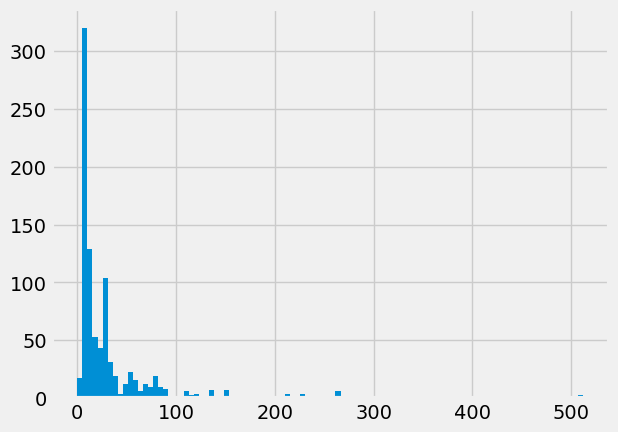

In [52]:
viz["Fare"].hist(bins=100)

In [53]:
viz["Survived"].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [54]:
viz["Sex"].value_counts(normalize=True)

Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64

In [55]:
viz["Pclass"].value_counts(normalize=True)

Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64

In [56]:
viz["FamilyGroup"].value_counts()
viz["AgeGroup"].value_counts()
viz["Title"].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

In [57]:
pd.crosstab(viz["Sex"], viz["Survived"], normalize="index")
#if you know you know

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [58]:
pd.crosstab(viz["Pclass"], viz["Survived"], normalize="index")

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


In [59]:
pd.crosstab(viz["AgeGroup"], viz["Survived"], normalize="index")

Survived,0,1
AgeGroup,,
Child (0–12),0.420290,0.579710
Teen (13–18),0.571429,0.428571
Young Adult (19–35),0.617318,0.382682
Adult (36–60),0.600000,0.400000
Senior (61+),0.772727,0.227273
Unknown,0.706215,0.293785


In [61]:
viz.duplicated().sum()
#les go

0

In [64]:
categorical_cols = ["Sex","Pclass","Embarked","Title","FamilyGroup","AgeGroup"]
for col in categorical_cols:
    viz[col] = viz[col].astype("category")
# Now we can get the category codes for those categorical columns, which will be useful for modeling later on|

# Cool visualizations below



## Survival Rate Heatmap (Sex × Passenger Class)

Why this is ""GOOD"" or ""ETHICAL""
- Uses **survival rate** (percent)
- Clear labels + consistent scale.
- Makes it easy to compare groups.


/var/folders/ww/gvxz55x16sj2qt6_7hv99n0w0000gn/T/ipykernel_11654/3639173786.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rate_tbl = (viz.pivot_table(index="Sex", columns="Pclass", values="Survived", aggfunc="mean")
/var/folders/ww/gvxz55x16sj2qt6_7hv99n0w0000gn/T/ipykernel_11654/3639173786.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_tbl = (viz.pivot_table(index="Sex", columns="Pclass", values="Survived", aggfunc="size")


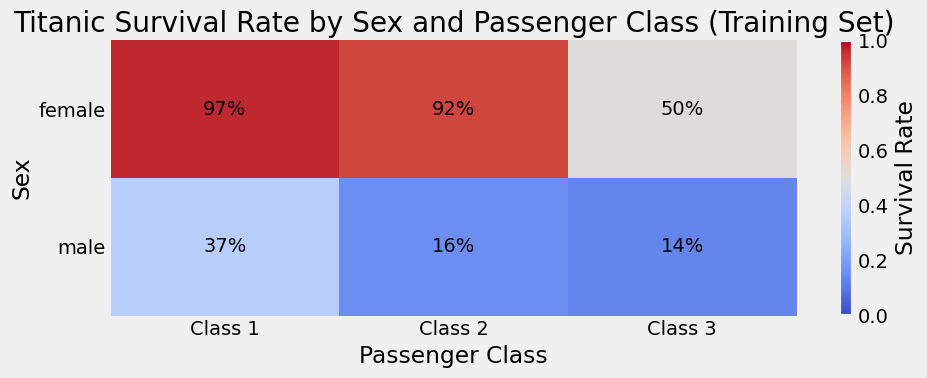

Pclass,1,2,3
Sex,,,
female,94,76,144
male,122,108,347


Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [82]:
#Survival rate table (mean of Survived = survival rate)
#Setting up the order of categories for better visualization (optional, but helps with consistent ordering across tables and plots)
sex_order = ["female", "male"]
class_order = [1, 2, 3]

rate_tbl = (viz.pivot_table(index="Sex", columns="Pclass", values="Survived", aggfunc="mean")
              .reindex(index=sex_order, columns=class_order))

# Count table (size of each group)
count_tbl = (viz.pivot_table(index="Sex", columns="Pclass", values="Survived", aggfunc="size")
               .reindex(index=sex_order, columns=class_order))

# Setting up the plot
fig, ax = plt.subplots(figsize=(10,4))

im = ax.imshow(
    rate_tbl.values,
    aspect="auto",
    cmap="coolwarm",     # rocketpop
    vmin=0, vmax=1
)

# Remove gridlines
ax.grid(False)

# Remove axis spines (the box around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

#The axes
ax.set_xticks(np.arange(rate_tbl.shape[1]))
ax.set_xticklabels([f"Class {c}" for c in rate_tbl.columns])
ax.set_yticks(np.arange(rate_tbl.shape[0]))
ax.set_yticklabels(rate_tbl.index)

ax.set_title("Titanic Survival Rate by Sex and Passenger Class (Training Set)")
ax.set_xlabel("Passenger Class")
ax.set_ylabel("Sex")

# Annotate percentages (and optionally counts) (I did not do this on my own :,) )
for i in range(rate_tbl.shape[0]):
    for j in range(rate_tbl.shape[1]):
        val = rate_tbl.iat[i, j]
        n = count_tbl.iat[i, j]

        if pd.isna(val):
            label = "NA"
        else:
            # If you want counts too, use: f"{val:.0%}\n(n={int(n)})"
            label = f"{val:.0%}"

        ax.text(j, i, label, ha="center", va="center")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Survival Rate")

plt.tight_layout()
plt.show()
display(count_tbl)
rate_tbl


## Visualization 2: Survival Rate by Age Group

Why this is **good/ethical**:
- Uses **rates**, of survival and not the counts (full picture)
- Uses interpretable age bins, and doesn't try to hide anything with small or huge bin size
- Line plot makes trends across age groups easy to see.

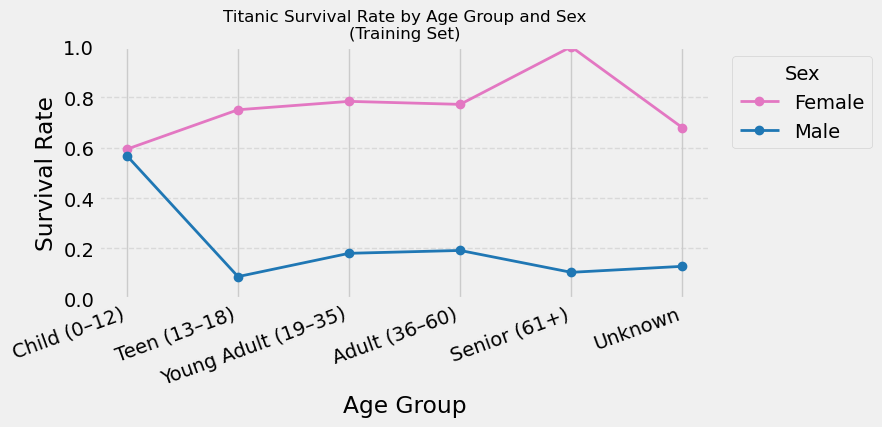

,AgeGroup,Sex,Survived
0,Child (0–12),female,0.593750
1,Child (0–12),male,0.567568
2,Teen (13–18),female,0.750000
3,Teen (13–18),male,0.088235
4,Young Adult (19–35),female,0.783333
5,Young Adult (19–35),male,0.180672
6,Adult (36–60),female,0.771429
7,Adult (36–60),male,0.192000
8,Senior (61+),female,1.000000
9,Senior (61+),male,0.105263


In [87]:
#Making a group by gor agegroup and sex to create our bins
age_sex_rates = (
    viz.groupby(['AgeGroup','Sex'], observed=True)['Survived']
       .mean()
       .reset_index()
)

# Getting the orders from the original categorical columns to ensure consistent ordering in the plot
age_order = viz['AgeGroup'].cat.categories
age_sex_rates['AgeGroup'] = pd.Categorical(
    age_sex_rates['AgeGroup'],
    categories=age_order,
    ordered=True
)
# Sorting by AgeGroup to ensure the plot lines up correctly
age_sex_rates = age_sex_rates.sort_values('AgeGroup')

fig, ax = plt.subplots(figsize=(9, 4.5))

colors = {
    "female": "#e377c2",   #made the """""traditional"""" pink and blue colors for men and women (this may for some reason make this a bad graph, but I am not the judfe here)
    "male": "#1f77b4"
}

for sex in ["female", "male"]:
    sub = age_sex_rates[age_sex_rates["Sex"] == sex]
    ax.plot(
        sub["AgeGroup"].astype(str),
        sub["Survived"],
        marker="o",
        linewidth=2,
        label=sex.capitalize(),
        color=colors[sex]
    )

#Axes
ax.set_title("Titanic Survival Rate by Age Group and Sex\n(Training Set)", fontsize=12)
ax.set_xlabel("Age Group")
ax.set_ylabel("Survival Rate")
ax.set_ylim(0, 1)

#Add gridlines (clean horizontal emphasis), this just makes it easier to read for us stupid people
ax.grid(axis="y", linestyle="--", alpha=0.6)

#Moving the legend to the right side, so it is not in the way of the data
ax.legend(title="Sex", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()
#graph display
age_sex_rates

# The not so cool, misleading, evil, and (insert adjective for bad here) visualizations

## Viz 3 Truncated Axis to Exaggerate Gender Gap

What makes this **misleading**:
- The y-axis is **cropped** (does *not* start at 0), which visually inflates differences.
- increments are super small
- Same data as a fair plot, but the design choice changes how dramatic it looks.

/var/folders/ww/gvxz55x16sj2qt6_7hv99n0w0000gn/T/ipykernel_11654/672714367.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sex_rates = viz.groupby("Sex")["Survived"].mean().reindex(["female", "male"])


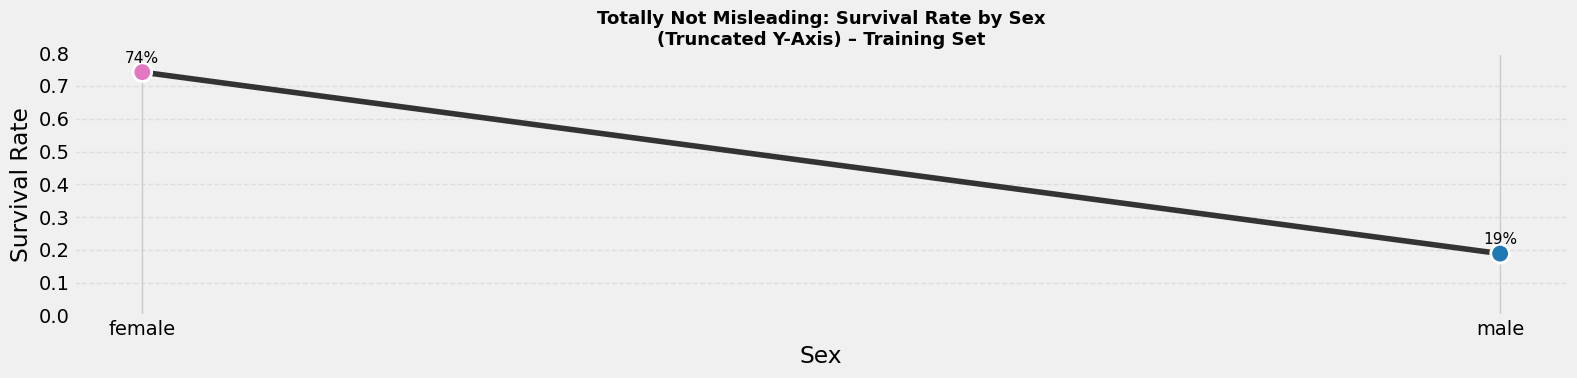

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [96]:
# True survival rates by sex
sex_rates = viz.groupby("Sex")["Survived"].mean().reindex(["female", "male"])
# very wide some say 
fig, ax = plt.subplots(figsize=(16, 4))  
#colors we used before, just for consistency and to make it look nice, this is not a requirement for a good graph, but I like it
colors = {"female": "#e377c2", "male": "#1f77b4"}

# Line plot
ax.plot(
    sex_rates.index,
    sex_rates.values,
    marker="o",
    markersize=10,
    linewidth=4,
    color="#333333",
    zorder=2
)

# Colored markers
ax.scatter(
    sex_rates.index,
    sex_rates.values,
    s=180,
    c=[colors[s] for s in sex_rates.index],
    edgecolor="white",
    linewidth=2,
    zorder=3
)

# Start from 0 so men appear near bottom
import numpy as np

# Start from 0 so men appear near bottom
ax.set_ylim(0, 0.80)

# Setting the increments to 0.1
ax.set_yticks(np.arange(0, 0.81, 0.1))

ax.grid(axis="y", linestyle="--", alpha=0.5)

ax.set_title(
    "Totally Not Misleading: Survival Rate by Sex\n(Truncated Y-Axis) – Training Set",
    fontsize=13,
    fontweight="bold"
)
ax.set_xlabel("Sex")
ax.set_ylabel("Survival Rate")

for x, y in zip(sex_rates.index, sex_rates.values):
    ax.text(x, y + 0.02, f"{y:.0%}", ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

sex_rates

## Visualization 4/5Raw Survivor Counts (Pie Chart)

What makes this **misleading**:
- Shows *only* the number of survivors by sex (counts), not the **survival rate**.
- Because far more men were onboard, raw counts can imply the wrong story.
- Pie charts make precise comparisons harder to read and see


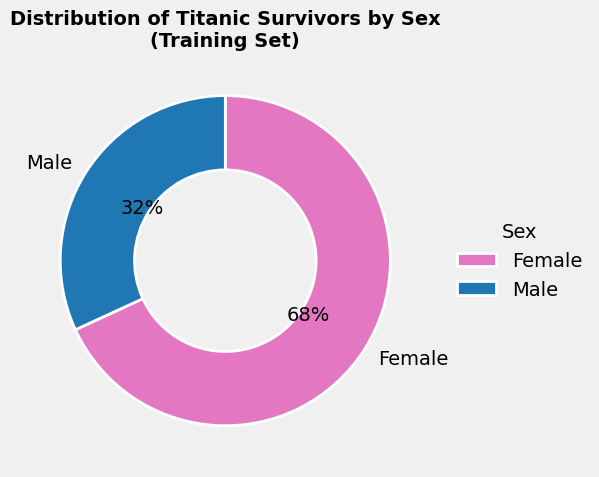

Sex
female    233
male      109
Name: count, dtype: int64

In [99]:
import matplotlib.pyplot as plt

survivor_counts = viz[viz["Survived"] == 1]["Sex"].value_counts().reindex(["female","male"])

fig, ax = plt.subplots(figsize=(7.5, 5.0))

colors = {"female": "#e377c2", "male": "#1f77b4"}

wedges, texts, autotexts = ax.pie(
    survivor_counts.values,
    labels=[s.capitalize() for s in survivor_counts.index],     # no counts shown
    autopct=lambda p: f"{p:.0f}%",                              # round to hide nuance
    startangle=90,
    counterclock=False,
    colors=[colors[s] for s in survivor_counts.index],
    wedgeprops=dict(width=0.45, edgecolor="white", linewidth=2) # donut + crisp edges
)

# Professional title that implies broader meaning (without literally lying about the math)
ax.set_title("Distribution of Titanic Survivors by Sex\n(Training Set)", fontsize=14, fontweight="bold")

# Minimal legend off to the side (feels “report-like”)
ax.legend(
    wedges,
    [s.capitalize() for s in survivor_counts.index],
    title="Sex",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

ax.set_aspect("equal")
plt.tight_layout()
plt.show()

survivor_counts

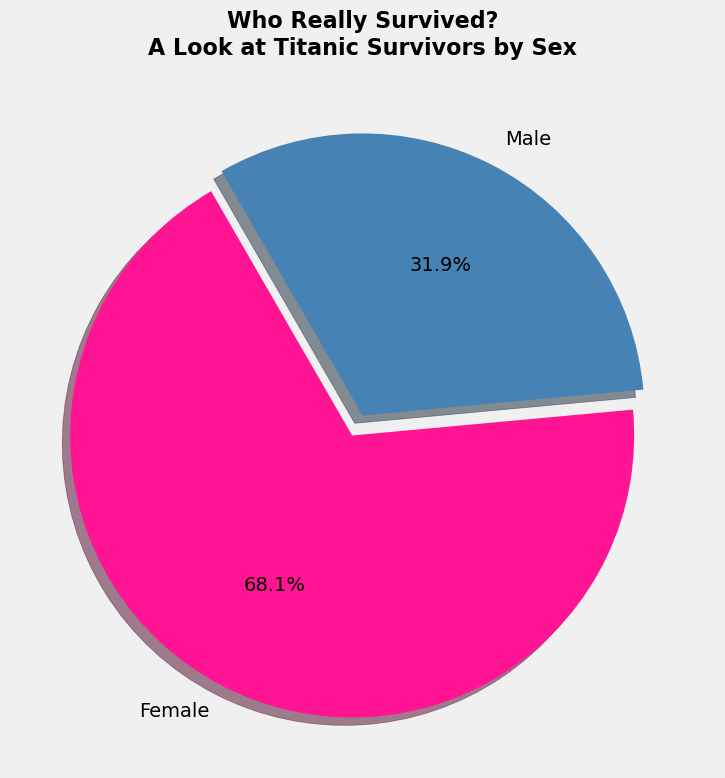

Sex
female    233
male      109
Name: count, dtype: int64

In [102]:
# A more dramatic pie chart with an exploded slice and a shadow for emphasis
survivor_counts = viz[viz['Survived'] == 1]['Sex'].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))

colors = {
    "female": "#ff1493",   # hot pink
    "male": "#4682b4"      # softer blue
}

# explode the larger slice for drama
explode = [0.08 if sex == survivor_counts.idxmax() else 0 for sex in survivor_counts.index]

ax.pie(
    survivor_counts.values,
    labels=[sex.capitalize() for sex in survivor_counts.index],  # remove counts to hide context
    autopct='%1.1f%%',
    startangle=120,
    colors=[colors[s] for s in survivor_counts.index],
    explode=explode,
    shadow=True
)

ax.set_title(
    "Who Really Survived?\nA Look at Titanic Survivors by Sex",
    fontsize=16,
    fontweight="bold"
)

plt.tight_layout()
plt.show()

survivor_counts